In [1]:
pip install neptune-client;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.1 MB/s eta 0:00:00


In [2]:
pip install neptune-notebooks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.7 MB/s eta 0:00:00
  Created wheel for neptune-notebooks: filename=neptune_notebooks-0.9.3-py2.py3-none-any.whl size=1074609 sha256=e0453914b724ed8ad1af05abd6cb89f161906e664d166abbcc7cf8c95ad0e3fc
  Stored in directory: /root/.cache/pip/wheels/16/32/72/b4fb207ede5ec809fa1e250b3c931d41bbfef41068f6189e68
Successfully built neptune-notebooks


In [3]:
pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.9 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import foolbox as fb
import torch.optim as optim
import neptune.new as neptune

trainMode = True
constrain = True
randd = random.randint(0,1000)
#randd = 528
print(f"Current random number : {randd}")
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Cifar100Experiments/ContractiveNetwork_100"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from utils import *
from NormalizedConvolutions import *
from networkTraining import *
from multiClassHinge import *
from LipschitzConstant import *
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-07ff5e67448b>:12: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


Current random number : 820
Mounted at /content/gdrive
/content/gdrive/My Drive/Cifar100Experiments/ContractiveNetwork_100
cuda:0


In [5]:
# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #cifar10
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #cifar100
])
batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
a = 0.5
M = 1

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Normalisation(torch.nn.Module):
    #def __init__(self, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.243, 0.261)): #cifar10
    def __init__(self,means=(0.485, 0.456, 0.406), stds=(0.229, 0.224, 0.225)): #cifar100
        super().__init__()
        assert len(means) == len(stds)
        self.means = means
        self.stds = stds
    
    def forward(self, x):
        return (x - torch.tensor(self.means, device=x.device).view(1, len(self.means), 1, 1)) / torch.tensor(self.stds, device=x.device).view(1, len(self.means), 1, 1)

transform_test_rob = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 1024
testset_rob = torchvision.datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test_rob)
testloader_rob = torch.utils.data.DataLoader(testset_rob, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
images, labels = next(iter(testloader_rob))
images, labels = images.to(device), labels.to(device)

Files already downloaded and verified


In [7]:
import time



 Now we are working with margin = 0.07




<ipython-input-8-579ad8437473>:16: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/geometricintegrationntnu/contrative-cnn-cifar100/e/CONTR100-22
Training with learning rate 0.0001
Initial regularization :  tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>) 


Regularization coefficient :  1 


epoch 0, rescalings_0 :  tensor([0.4757, 0.6222, 3.5436], device='cuda:0')
epoch 0, rescalings_1 :  tensor([0.6231, 0.9180, 4.2001], device='cuda:0')
epoch 0, rescalings_2 :  tensor([0.8872, 0.7665, 4.7670], device='cuda:0')
Loss [1, 100](epoch, minibatch):  0.5370736062526703
Loss [1, 200](epoch, minibatch):  0.5194997829198837
Loss [1, 300](epoch, minibatch):  0.5138812208175659
epoch 0, dts_0 :  tensor([0.7819, 0.9140, 1.1224, 0.0000], device='cuda:0')
epoch 0, dts_1 :  tensor([0.0000, 0.0000, 1.8309, 0.3878], device='cuda:0')
epoch 0, dts_2 :  tensor([1.7953, 0.3604, 0.0000, 0.8282], device='cuda:0')
Norms: [1.000656247138977, 0.998155951499939, 0.999092698097229, 0.9999611973762512, 1.0000011920928955, 0.9999984502792358, 0.9937909841537476, 0.

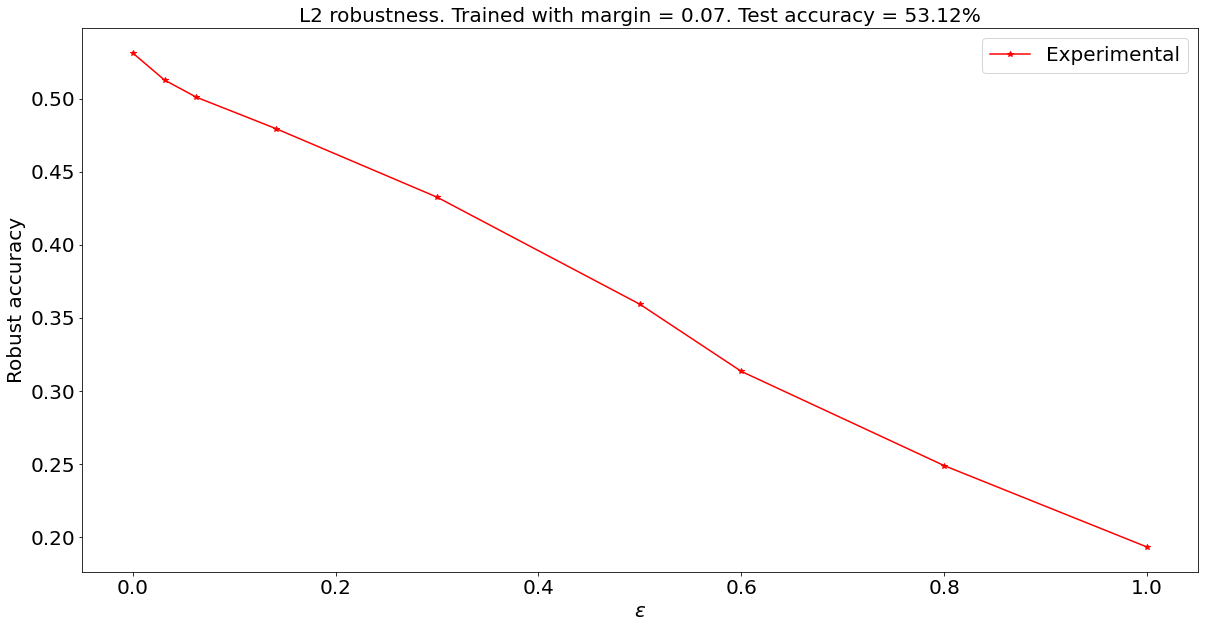

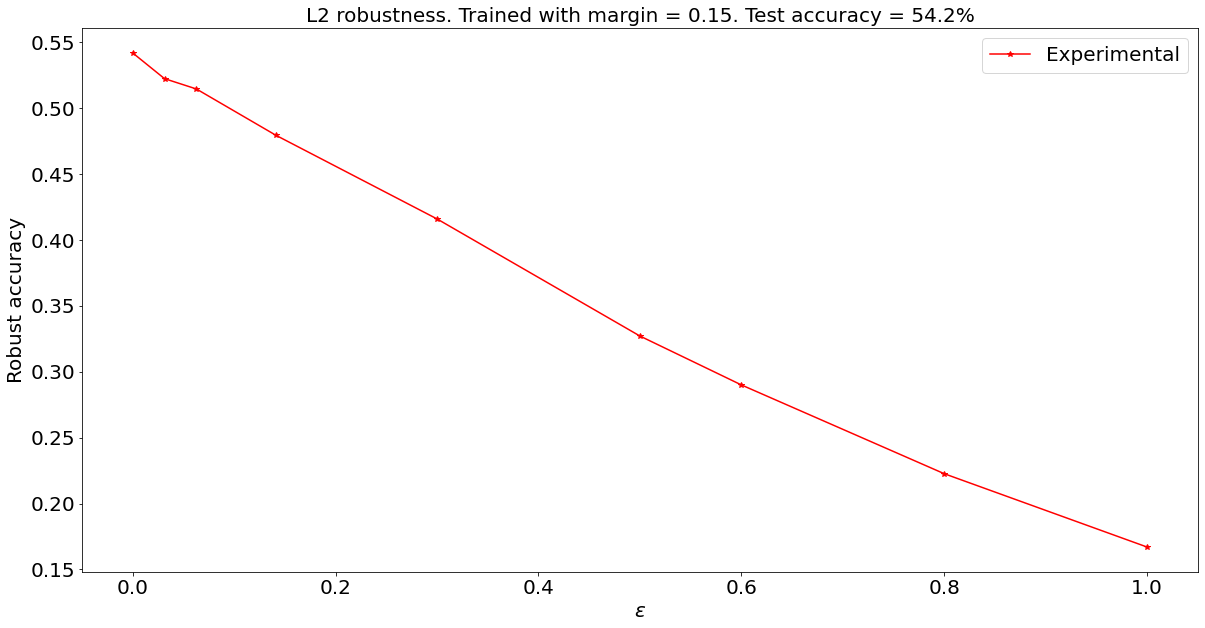

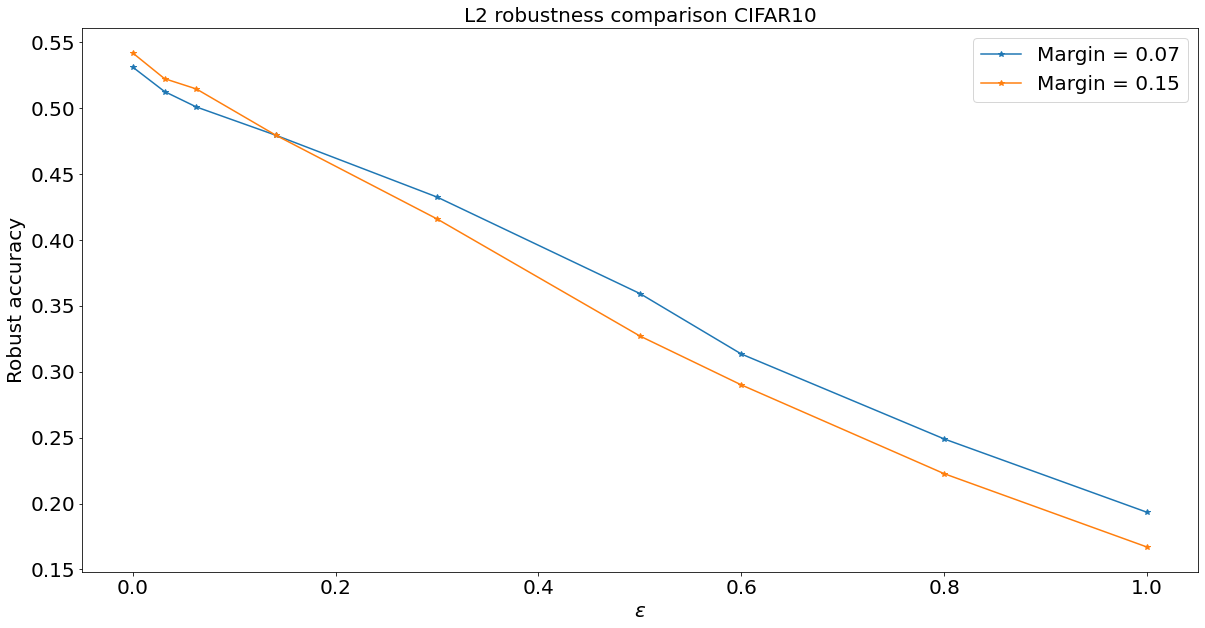

In [ ]:
#marginList = [0.05, 0.07, 0.1, 0.15,0.3, 0.5]
marginList = [0.07,0.15]
#marginList = [0.15]
#marginList = [0.07]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]
saveRobAcc = np.zeros((len(marginList),len(epsilons)))
it = 0
for num,margin in enumerate(marginList):

  print(f"\n\n Now we are working with margin = {margin}\n\n")

  net = Network(3,32,64,128,4,4,4,S = 2, a = a, M=M)
  net.to(device);
  pretrained_dict = torch.load(f"CertifiedLip_margin_{margin}.pt")
  net.load_state_dict(pretrained_dict, strict=False)
  run = neptune.init_run(
    project="geometricintegrationntnu/contrative-cnn-cifar100",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2YzM5YjI2My1kYTI2LTRhNmMtOWI5Ni1lYzlmYzBiZWZiNzIifQ==",
)  # your credentials

  criterion = multiClassHingeLoss(margin = margin)
  #criterion = torch.nn.MultiMarginLoss(p=1, margin=margin)
  lr = 1e-4
  
  optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)#,weight_decay=1e-4)
  #optimizer = optim.Adam(net.parameters(),lr=lr)#,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
  
  model_save_name = f'CertifiedLip_margin_{margin}.pt'
  path = F"{model_save_name}" 

  if trainMode:
    loss = -1
    while loss<0:
      print(f"Training with learning rate {lr}")
      loss = train(net, margin, criterion, optimizer, scheduler, trainloader, testloader, device, epochs=100, reg=True, a=a, constrain = constrain, gamma = 1, run=run)
      if loss<0:
        net = Network(3,32,64,128,4,4,4,S=2,a=a,M=M)
        net.to(device);
        #net.load_state_dict(pretrained_dict, strict=False)
        run = neptune.init_run(
        project="geometricintegrationntnu/contrative-cnn-cifar100",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2YzM5YjI2My1kYTI2LTRhNmMtOWI5Ni1lYzlmYzBiZWZiNzIifQ==",
    )  # your credentials
        lr/=10
        optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)#,weight_decay=1e-4)
        #optimizer = optim.Adam(net.parameters(),lr=lr)#,weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)


    torch.save(net.state_dict(), path)
    print("waitinig 60 seconds to save stuff on neptune")
    time.sleep(60)
    run["trained model"].upload(path)
    run.stop()
  else:
    net.load_state_dict(torch.load(path))
  
  model = nn.Sequential(Normalisation(),net).eval()
  fmodel = fb.PyTorchModel(model, bounds=(0, 1))

  acc = fb.utils.accuracy(fmodel, images, labels)

  attack = fb.attacks.L2PGD(steps=10)
  _, advs, success = attack(fmodel, images, labels, epsilons=epsilons)
  robust_accuracy = torch.mean((1-1.*success),axis=1)
  saveRobAcc[num] = robust_accuracy.detach().cpu().numpy()

  it += 1
  destination = f"updateMargin_{margin}.txt"
  np.savetxt(destination, saveRobAcc.reshape(-1,1))

  fig = plt.figure(figsize=(20,10))
  plt.plot(epsilons,robust_accuracy.detach().cpu().numpy(),'r-*',label="Experimental")
  plt.xlabel(r"$\varepsilon$",fontsize=20)
  plt.ylabel("Robust accuracy",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.legend(fontsize=20,loc=1)
  plt.title(f"L2 robustness. Trained with margin = {margin}. Test accuracy = {round(acc * 100,2)}%",fontsize=20);

  plt.savefig(f'L2margin_{margin}.png')
  
fig = plt.figure(figsize=(20,10))

for i in range(len(marginList)):
  plt.plot(epsilons,saveRobAcc[i],'-*',label=f"Margin = {marginList[i]}")

plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel("Robust accuracy",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc=1)
plt.title(f"L2 robustness comparison CIFAR10",fontsize=20);

plt.savefig(f'L2RobustnessComparison.png')